Textual data, is said to be the most available and the most unorganised form of data, and most organisations fail to manipulate its raw form, hence this huge resource for very useful insights gets wasted! In this notebook, I have explored various preprocessing techniques, ranging from basic TF-IDF matrix to tokenizers provided by the state-of-art NLP models- 
Google's BERT(Bidirectional Encoder Representations from Transformers) on the data to generate useful features.

In [1]:
#importing input files
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-multilingual-cased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-chinese-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-multilingual-uncased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-cased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-uncased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-large-cased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-large-uncased-vocab.txt
/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-multilingual-cased/bert_config.json
/kaggle/input/

In [2]:
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
#pandas profiling to observe the distributions in the data
import pandas_profiling
fake_report = pandas_profiling.ProfileReport(fake_df)

In [6]:
fake_report

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
fake_df.drop_duplicates(inplace = True)

In [8]:
real_report = pandas_profiling.ProfileReport(real_df)

In [9]:
real_report

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
real_df.drop_duplicates(inplace = True)

In [11]:
fake_df['label'] = 1
real_df['label'] = 0

In [12]:
#concat and shuffle real and fake dataset
data = pd.concat([fake_df,real_df],axis = 0)
data = data.sample(frac = 1)
data.reset_index(drop=True,inplace = True)
data.head()

,title,text,subject,date,label
0,Trump Just Got BURNED In An Epic Poem Written...,Donald Trump will explode when he reads this.T...,News,"April 2, 2017",1
1,BREAKING: Sources Reveal Trump HIMSELF Met Wi...,In what could be the most damning information ...,News,"March 7, 2017",1
2,New Poll Is DEVASTATING News For Trump – It’s...,"A new Politico/Morning Consult poll is out, an...",News,"May 31, 2017",1
3,U.S. intelligence chiefs call Russia 'major' c...,WASHINGTON (Reuters) - Russia is a major threa...,politicsNews,"January 5, 2017",0
4,Conservative Indiana Governor’s Stupid Respon...,Indiana Governor Mike Pence is at the center o...,News,"February 12, 2016",1


In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import regex as re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

from textblob import TextBlob, Word

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
subj = []
for sub in data['subject']:
    sub = sub.lower()
    sub = re.sub(" ", '',sub)
    sub = re.sub("-",'',sub)
    sub = re.sub("_",'',sub)
    subj.append(sub)
data['subject'] = subj

# Feature Engineering on News Title:

The title of a news article is very useful to detect fake news, few of the reasons such as due to their style of casing (first letter of every word capitalised), polarity of the language, use of informal or obnoxious style of writing. Hence, the title can be used to generate many useful insights about the news articles, some of which I have explored below:

In [15]:
# generate sentiment subjectivity, polarity 
def sentiment_polarity(data,clean_col):
    subjectivity = []
    polarity = []
    sense = []
    for text in data[clean_col]:
        subjectivity.append(TextBlob(text).sentiment.subjectivity)
        pol = TextBlob(text).sentiment.polarity
        polarity.append(pol)
        if pol>0:
            sense.append(1)
        elif pol<0:
            sense.append(-1)
        else:
            sense.append(0)
    return subjectivity, polarity, sense

sub,pol,sentiment = sentiment_polarity(data,'title')

In [16]:
data['subjectivity'] = sub
data['polarity'] = pol
data['sentiment_polarity'] = sentiment

In [17]:
import plotly.express as px
fig = px.box(data, x="sentiment_polarity", y="subjectivity",color="label")
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.show()

Subjectivity of the title is more for fake news, irrespective of their sentiment polarity, it is so, because probably the writers of these fake news try to include a lot of weird facts to make it a clickbait for readers. Real news, which generally are neutral reports try making it as concise as possible!

Stemming and Lemmatizing a chunk of data, makes it easier for the machine to identify numerous words from their root form, which is essential for semantic analysis of the data, generating tokens and embeddings for words in the doc, which are very useful to perform deep learning on the data. <br>
Raw form of data should also be cleaned to remove stopwords, punctuations and at times, if nessacary, rare words to prevent crowding by regular pronouns, models, verbs and spell errors which do not really contribute to understanding the subject of the sentence.<br>
But, a point to be noted, for generating embeddings (for a sequence of words in a sentence) which will further be used for training deep learning models, removal of stop words is not a good practice because doing so breaks the flow of the language which is nessaccary for the deep learning model to learn.

In [18]:
# removing stopwords, punctuations and obtain stemmed and lemmatized form of data
stopwords_en = set(stopwords.words('english'))
def clean_data(data,col):
    stemmed_col = []
    lemmatized_col = []
    for text in data[col]:
        sent = text.lower()
        sent = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                    '', sent, flags=re.MULTILINE)
        sent = re.sub(r'[^\w\s]', '', sent) 
        ps = PorterStemmer()
        stemmed_text = " ".join([ps.stem(word) for word in sent.split() if word not in stopwords_en and not word.isdigit()])
        stemmed_col.append(stemmed_text)
        
        sent = TextBlob(sent)
        lemmatized_text = " ".join([word.lemmatize() for word in sent.words if word not in stopwords_en and not word.isdigit()])
        lemmatized_col.append(lemmatized_text)
        
    return stemmed_col, lemmatized_col

In [19]:
stemmed_col, lemmatized_col = clean_data(data,'title')

In [20]:
data['stemmed_title'] = stemmed_col
data['lemmatized_title'] = lemmatized_col

In [21]:
data.tail()

,title,text,subject,date,label,subjectivity,polarity,sentiment_polarity,stemmed_title,lemmatized_title
44684,Trump to meet Indiana Governor Mike Pence over...,WASHINGTON (Reuters) - Donald Trump will meet ...,politicsnews,"July 1, 2016",0,0.000000,0.000000,0,trump meet indiana governor mike penc weekend,trump meet indiana governor mike penny weekend
44685,FIRST FAMILY FATHER’S DAY: “Rustic” Camp David...,Did President Trump visit Camp David this Fath...,politics,"Jun 18, 2017",1,0.333333,0.250000,1,first famili father day rustic camp david inla...,first family father day rustic camp david inla...
44686,COMMIE OBAMA BASHES AMERICA: “I personally wou...,Wow! We REALLY do have a serious problem with ...,politics,"Mar 21, 2016",1,0.300000,0.000000,0,commi obama bash america person would disagre ...,commie obama bash america personally would dis...
44687,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",worldnews,"September 26, 2017",0,0.000000,0.000000,0,palestinian gunman kill three isra guard west ...,palestinian gunman kill three israeli guard we...
44688,New Jersey 'Bridgegate' judge delays closing a...,"NEWARK, N.J. (Reuters) - Closing arguments in ...",politicsnews,"October 27, 2016",0,0.454545,0.136364,1,new jersey bridgeg judg delay close argument,new jersey bridgegate judge delay closing argu...


In [32]:
# create vocabulary of words used in titles
import wordcloud
import matplotlib.pyplot as plt

def gen_vocab(data,col,label):
    vocab =  {}
    data = data.loc[data['label'] == label]
    for text in data[col]:
      sen = text.split()
      for word in sen:
        try:
          vocab[word] += 1
        except KeyError:
          vocab[word] = 1
    vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))
    vals = " ".join(w for w in vocab.keys())
    w = wordcloud.WordCloud().generate(vals)
    plt.imshow(w, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return vocab

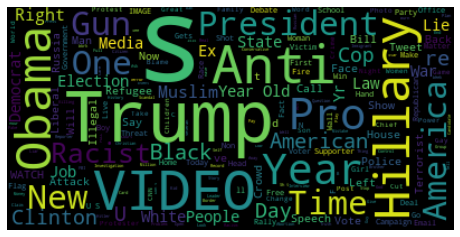

In [34]:
vocab_fake_title_unclean = gen_vocab(data,'title',1)

A collection of most frequent words from the unfiltered titles of fake data. There is Trump,Obama,Hillary, and also we see words like Gun, Cop, Black, Muslim, Racist, American, Right, Lie, which shows they always attack sensitve and delicate social and political issues to attract readers and influence them!

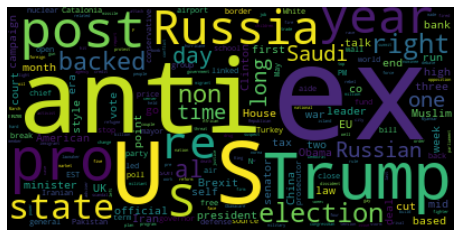

In [35]:
vocab_real_title_unclean = gen_vocab(data,'title',0)

The collection of words from the unfiltered titles of real news data. We can see that they mostly focus on countries in relation with the United States, such as Russia, Saudi, UK,other than the common occurence of the word Trump. We can also see words like Anti, Ex and Post, probably focusing on the relations with the country or the politicians maybe. They don't touch social issues much compared to fake news.

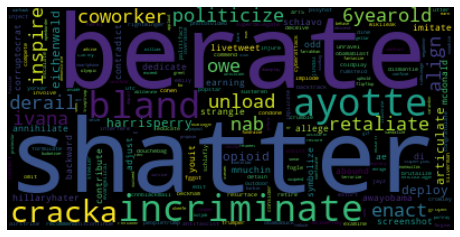

In [37]:
vocab_fake_title_clean = gen_vocab(data,'lemmatized_title',1)

Lemmatized titles highlight the common verbs occuring in the titles. For the fake titles, We see words like politicize, shatter, berate, incriminate, 6 year old(wonder why!?)etc. We can make somewhat sense the kind of language fake news makers use.

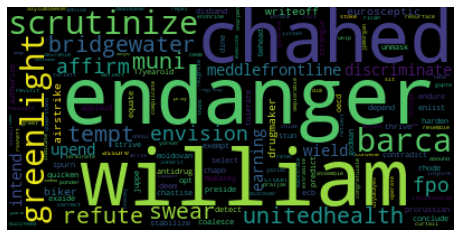

In [38]:
vocab_real_title_clean = gen_vocab(data,'lemmatized_title',0)

For the real news titles we can spot words like endanger, scrutinize, swear, refute and nouns like william, chahed(politician), barca etc.

We can use the vocabularies we generated to filter out rare words from texts, which is completely optional!

In [42]:
def rare_words(vocab):
    rare_words = []
    for key,value in vocab.items():
      if value<=5:
        rare_words.append(key)
    return rare_words

In [43]:
rare_words_fake_title = rare_words(vocab_fake_title_clean)
rare_words_real_title = rare_words(vocab_real_title_clean)

Now we can use these list of words to remove these words from the titles, with the help of regex or replace.

# Feature Engineering on News Body:

News body is a big chunk of insightful information, which can be used to summarise the content of the article, generate name entity recognizers which can be used to identify imortant information or terms in the article, answer questions about the news, ofcourse with the help of new state of art models. 

For statistical analysis, we can count the number of words, sentences, approx lengths, to see if there is any significant difference between the real and fake news on the basis of these features. We can also obtain n-grams with the help of tf-idf vectorizers, which can be further used for semantic analysis on the data. I have explored a few of these techniques to obtain useful features!

In [46]:
## word count, sentence count, average lengths
data['word_count_body'] = data["text"].apply(lambda x: len(str(x).split(" ")))
data['char_count_body'] = data["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count_body'] = data["text"].apply(lambda x: len(str(x).split(".")))
data['avg_word_length_body'] = data['char_count_body'] / data['word_count_body']
data['avg_sentence_lenght_body'] = data['word_count_body'] / data['sentence_count_body']
data.head()

,title,text,subject,date,label,subjectivity,polarity,sentiment_polarity,stemmed_title,lemmatized_title,word_count_body,char_count_body,sentence_count_body,avg_word_length_body,avg_sentence_lenght_body
0,Trump Just Got BURNED In An Epic Poem Written...,Donald Trump will explode when he reads this.T...,news,"April 2, 2017",1,0.400000,0.100000,1,trump got burn epic poem written 14yearold boy,trump got burned epic poem written 14yearold boy,619,2946,35,4.759289,17.685714
1,BREAKING: Sources Reveal Trump HIMSELF Met Wi...,In what could be the most damning information ...,news,"March 7, 2017",1,0.000000,0.000000,0,break sourc reveal trump met russian ambassado...,breaking source reveal trump met russian ambas...,392,1870,22,4.770408,17.818182
2,New Poll Is DEVASTATING News For Trump – It’s...,"A new Politico/Morning Consult poll is out, an...",news,"May 31, 2017",1,0.538636,-0.340909,-1,new poll devast news trump wors slip approv rate,new poll devastating news trump worse slipping...,412,1995,17,4.842233,24.235294
3,U.S. intelligence chiefs call Russia 'major' c...,WASHINGTON (Reuters) - Russia is a major threa...,politicsnews,"January 5, 2017",0,0.500000,0.062500,1,us intellig chief call russia major cyber thre...,u intelligence chief call russia major cyber t...,91,549,9,6.032967,10.111111
4,Conservative Indiana Governor’s Stupid Respon...,Indiana Governor Mike Pence is at the center o...,news,"February 12, 2016",1,0.433333,-0.333333,-1,conserv indiana governor stupid respons lgbt q...,conservative indiana governor stupid response ...,398,1904,19,4.783920,20.947368


In [47]:
## plot word counts of fake and real news data
fig = px.box(data, x="sentiment_polarity", y="word_count_body",color="label")
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.show()

We can see that fake news have significantly more number of words than real news. Now that's a good discovery, though not very dependable!

In [48]:
##stemming and lemmatizing body text
## This is a very time consuming method, any optimized solution is most welcome in the comments below!
stemmed_col , lemmatized_col = clean_data(data,'text')

In [49]:
data['stemmed_body'] = stemmed_col
data['lemmatized_body'] = lemmatized_col

In [50]:
## TF-IDF vectorizer on body text to obtain bi-grams and tri- grams of the dataset.
vectorizer = TfidfVectorizer(ngram_range=(2, 3),max_features=20000,smooth_idf=True)
tfidif_matrix = vectorizer.fit_transform(data['lemmatized_body'])
print(tfidif_matrix.shape)
print(vectorizer.get_feature_names()[:50])

(44689, 20000)
['100member senate', '100seat senate', '19th century', '2016featured image', '2016featured image via', '2017donald trump', '2017featured image', '2017featured image via', '2017of course', '2017president trump', '2017twitter user', '20th century', '21st century', '21st century wire', '21wire acr', '21wire acr contributor', '21wire reported', '21wire shawn', '21wire subscribe', '21wire subscribe become', '2nd amendment', '45th president', '45th president united', '49ers quarterback', '4th circuit', '4th circuit court', '5star movement', '5th circuit', '9th circuit', '9th circuit court', 'abc cbs', 'abc news', 'abc news abc', 'abc news politics', 'abc week', 'abdel fattah', 'abdel fattah alsisi', 'abdrabbu mansour', 'abdrabbu mansour hadi', 'abdullah saleh', 'abe said', 'able find', 'able get', 'able make', 'able reach', 'able see', 'able take', 'able use', 'able vote', 'able work']


We can obtain embedding vectors from pre-trained embedding models, which can be used to create an embedding matrix, which is a good parameter to feed into the embedding layer of a sequential deep learning model. Embeddings are useful to study similarities of different words, hence obtain corresponding vectors which are essential for studying sequences and sequence classifcation by deep learning models.

I have used the GloVe model 200 dimensional embeddings, to generate vectors for this dataset.

In [51]:
## Load word vectors
embeddings_index = dict()
f = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt')
for line in f:
  values = line.split()
  word = values[0]
  try:
    coefs = np.asarray(values[1:], dtype='float32')
  except ValueError:
    pass
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [52]:
## obtain sequnece of tokens from data
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(data['lemmatized_body'])
body_sequence = tokenizer.texts_to_sequences(data['lemmatized_body'])
body_sequence = sequence.pad_sequences(body_sequence,maxlen=200)

In [55]:
## This generates a huge dictionary, hence I have commented it out, you could have a look if you want!
##print(tokenizer.word_counts)

In [56]:
## obtain word vectors for tokens from our dataset
tokens = len(tokenizer.word_index) + 2
embedding_matrix = np.zeros((tokens, 200))
count = 0
unknown = []
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    unknown.append(word)
    count += 1

In [58]:
print(f'Percentage of obtained word vectors for our dataset : {100*(1-(count/len(tokenizer.word_index)))} %')

Percentage of obtained word vectors for our dataset : 47.28683798006942 %


This embedding matrix can now be used as weights for an embedding layer to train a deep learning model!:)

The HuggingFace🤗  library provides a range of state of art transformer models, pre-processing methods for natural language processsing, understanding, text generation, intent classification,question answering and much more. <br>You can read more about these models on their website: [https://huggingface.co/transformers/index.html](http://)<br>In this notebook, I am exploring their tokenizers, transformer pipelines, processors etc. to learn and tune to get the most optimised results. My work is still under progress, so stay tuned for more techniques!

In [59]:
#!pip install tokenizers

In [62]:
## Token generation by the BERT tokeniser
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer("/kaggle/input/pretrained-bert-models-for-pytorch/bert-base-uncased-vocab.txt")

def bert_tokenizer(data,col):
    encoded_output = []
    for i in data[col]:
        encoded = tokenizer.encode(i)
        encoded_output.append(encoded)
    return encoded_output
data['encoded_body'] = bert_tokenizer(data,'lemmatized_body')

In [64]:
data['encoded_body'][:2]

0    Encoding(num_tokens=364, attributes=[ids, type...
1    Encoding(num_tokens=233, attributes=[ids, type...
Name: encoded_body, dtype: object

In [69]:
encoded_sent = data['encoded_body'][0]
encoded_sent.offsets
encoded_sent.tokens

['[CLS]',
 'donald',
 'trump',
 'explode',
 'read',
 'national',
 'embarrassment',
 'never',
 'allowed',
 'run',
 'presidency',
 'begin',
 'anti',
 '##c',
 'campaign',
 'divided',
 'country',
 'turned',
 'u',
 'laughing',
 '##stock',
 'around',
 'campaign',
 'trump',
 'attacked',
 'latino',
 'woman',
 'african',
 '##ame',
 '##rica',
 '##ns',
 'muslim',
 'jew',
 'constantly',
 'bull',
 '##ied',
 'threatened',
 'people',
 'even',
 'urged',
 'russia',
 'hack',
 'hillary',
 'clinton',
 'taking',
 'office',
 'trump',
 'disastrous',
 'country',
 'scandal',
 'rack',
 '##ing',
 'much',
 'frequent',
 'golf',
 'trip',
 'clear',
 'trump',
 'incapable',
 'governing',
 'res',
 '##pon',
 '##si',
 '##bly',
 'ethical',
 '##ly',
 'trump',
 'also',
 'embarrassed',
 'repeatedly',
 'twitter',
 'often',
 'open',
 'mouth',
 'keep',
 '14',
 '##year',
 '##old',
 'owen',
 'pal',
 '##len',
 '##berg',
 'wrote',
 'poem',
 'trump',
 'campaign',
 'various',
 'anti',
 '##c',
 'time',
 'present',
 'day',
 'race',
 'b

HuggingFace transformers provide a set of pipelines which are pre-trained to undergo complex functions such as sentiment analysis, name entity recognizers, summaries and even answer questions! to name a few. I have explored a few of these piplines to gain insight and features from our dataset. <br>
Since these pipelines take up a lot of RAM, it is advised to use them as and when required only!

In [70]:
import transformers
from transformers import pipeline

In [73]:
## Obtain sentiment Analysis of the news body
sentimentAnalysis = pipeline("sentiment-analysis")

## The following loop isn't an optimised way to 
## obtain analysis of a large amount of data hence 
## i have commented it out.
# sentiment_analysis = []
# for body in data['lemmatized_title']:
#     sentiment = sentimentAnalysis(body)
#     sentiment_analysis.append(sentiment)
# print (sentiment_analysis[:5])

body = data['lemmatized_body'][0]
print(sentimentAnalysis(body))

[{'label': 'NEGATIVE', 'score': 0.9934436678886414}]


In [74]:
## Name entity recognizers 
namedEntityRecgnition = pipeline("ner")

## The following loop isn't an optimised way to 
## obtain analysis of a large amount of data hence 
## i have commented it out.
# ner_body = []
# for body in data['lemmatized_body']:
#     neR = namedEntityRecgnition(body)
#     ner_body.append(neR)
# print (sentiment_analysis[:5])

print(namedEntityRecgnition(body))

Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

[{'word': '##rica', 'score': 0.6704599261283875, 'entity': 'I-LOC', 'index': 33, 'start': 184, 'end': 188}, {'word': '##rica', 'score': 0.7218714952468872, 'entity': 'I-MISC', 'index': 35, 'start': 192, 'end': 196}, {'word': '##uss', 'score': 0.34851109981536865, 'entity': 'I-LOC', 'index': 50, 'start': 259, 'end': 262}, {'word': '##eric', 'score': 0.6288037896156311, 'entity': 'I-MISC', 'index': 159, 'start': 804, 'end': 808}, {'word': '##eric', 'score': 0.4074943959712982, 'entity': 'I-MISC', 'index': 297, 'start': 1582, 'end': 1586}, {'word': '##eric', 'score': 0.6781802177429199, 'entity': 'I-MISC', 'index': 370, 'start': 1951, 'end': 1955}]


In [75]:
## Extract summary of the data
summarizer = pipeline('summarization')
## The following loop isn't an optimised way to 
## obtain analysis of a large amount of data hence 
## i have commented it out.
# summary = []
# for body in data['lemmatized_body']:
#     sum = summarizer(body)
#     summary.append(sum)
# print (summary[:5])

print(summarizer(body))

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

[{'summary_text': ' 14-year-old owen pallenberg wrote poem trump campaign various antic time present day race begin campaign take u depressing election concludes aftermath done rid country full poem via huffington posta man woman running man dressed red orange face and woman dressed blue pantsuit race much longer dash mile marathon .'}]


The above generated features of the news body can be used for analysis and gaining useful insights. So far we have generated a large number of features, which can be used for modelling and predictions. Stay tuned for more ideas on feature engineering in NLP!

# Work Under Progress!

Please Leave an upvote if you like my notebook! Any suggestions or corrections are welcome in the comments below, thanks!